# Receptive Field Analysis
This notebook demonstrates how to run the `brain_observatory.receptive_field_analysis` module.  This module uses a cell's responses to the locally sparse noise stimulus to characterize the spatial receptive field, including on and off subunits.  We highly recommend reading through the the stimulus analysis <a href='http://help.brain-map.org/display/observatory/Documentation]'>whitepaper</a> to understand the locally sparse noise stimulus and the analysis methodology.

Download this file in .ipynb format <a href='receptive_fields.ipynb'>here</a>.

First we import packages.

In [1]:
import numpy as np
import torch
import tensorflow as tf
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.parameter import Parameter

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.receptive_field_analysis.visualization as rfvis
import allensdk.brain_observatory.receptive_field_analysis.receptive_field as rf
from allensdk.brain_observatory.receptive_field_analysis.eventdetection import detect_events
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jothi/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Given a cell of interest, we now identify the experiment that contains the locally sparse noise stimulus and download its NWB file.  We also look in the NWB file to figure out the position/index of the cell that has the ID we're interested in.

In [2]:
cell_specimen_id = 517475591

boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id],
                                 stimuli=['drifting_gratings'])

data_set = boc.get_ophys_experiment_data(501498760)

cell_index = data_set.get_cell_specimen_indices([cell_specimen_id])[0]

print("cell %d has index %d" % (cell_specimen_id, cell_index))

cell 517475591 has index 104


## Compute receptive fields
The following method in the `receptive_field_analysis` module will characterize on and off receptive fields and perform a per-pixel significance test.

In [3]:
# Get the neural activity for the first neuron
ts, dff = data_set.get_dff_traces()
n = 107
Yn = dff[n, :]
T = len(Yn)

In [4]:
# Get the stimulus at each "frame"
stimulus_table = data_set.get_stimulus_table('natural_scenes')
stimulus_template = data_set.get_stimulus_template('natural_scenes')[stimulus_table['frame'].values, :, :]

In [5]:
T_frames, s1, s2 = stimulus_template.shape

In [6]:
x = np.zeros(212)
for i in range(212):
    S = detect_events(data_set, i, "natural_scenes")
    x[i] = S.sum()

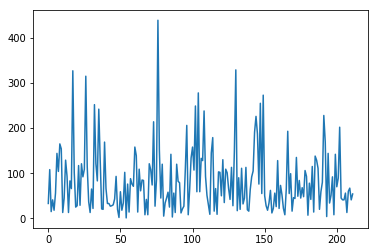

In [7]:
plt.plot(x)

In [8]:
sort = x.argsort()

In [9]:
max_x = np.zeros(25)
for i in range(25):
    max_x[i] = sort[len(sort) - 1 - i]

In [10]:
neuron_indices = sort[::-1][:25]

/Users/jothi/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


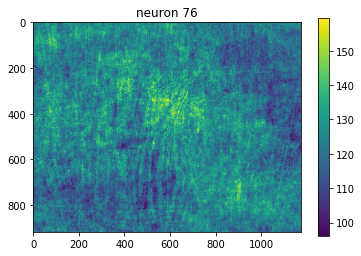

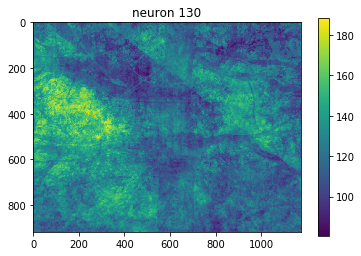

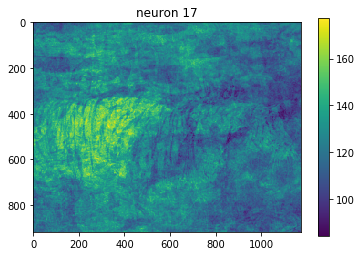

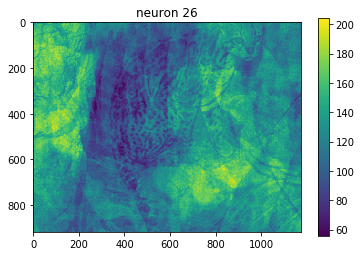

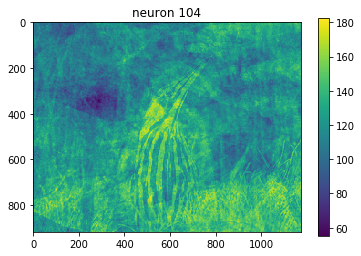

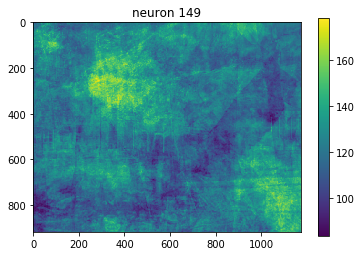

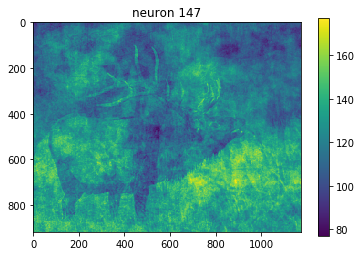

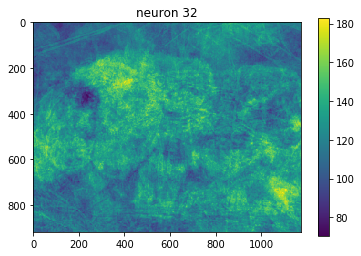

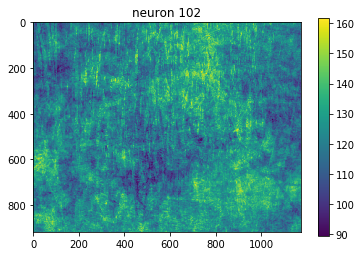

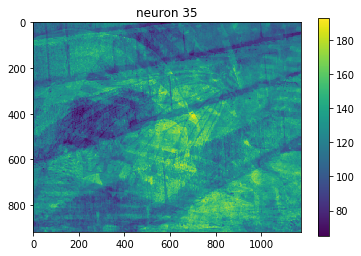

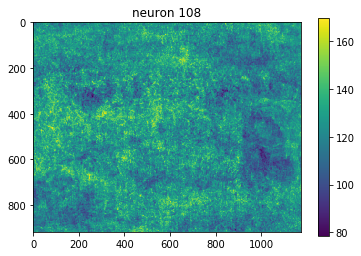

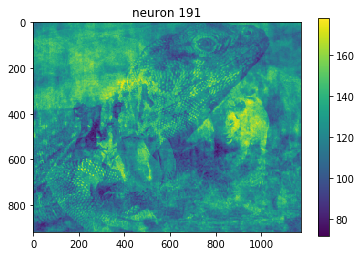

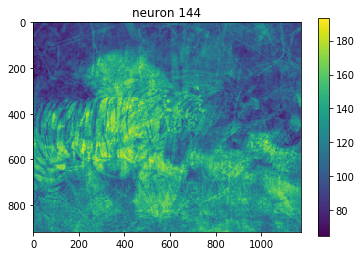

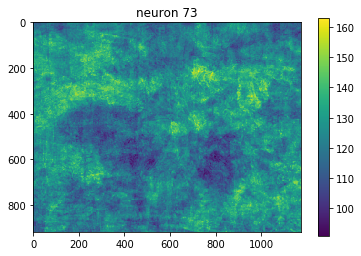

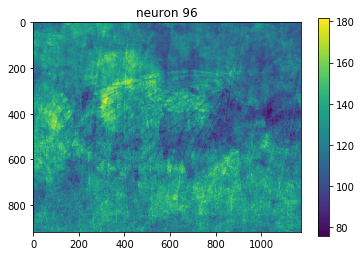

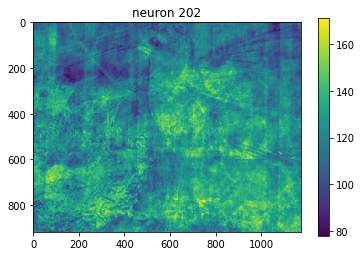

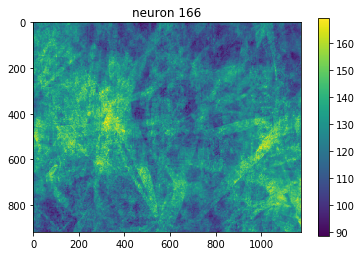

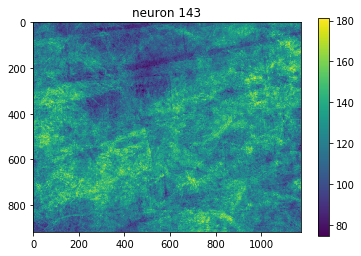

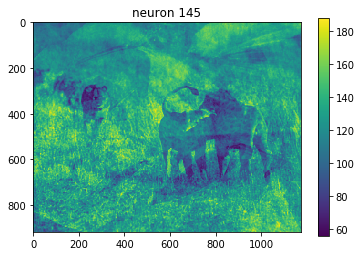

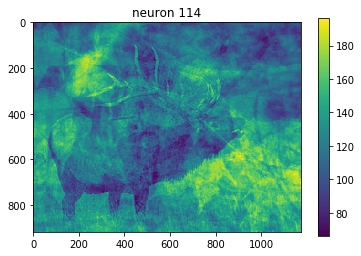

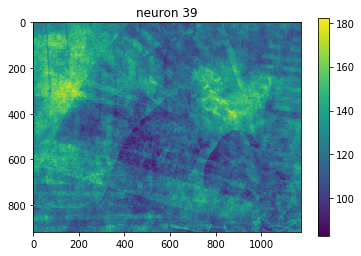

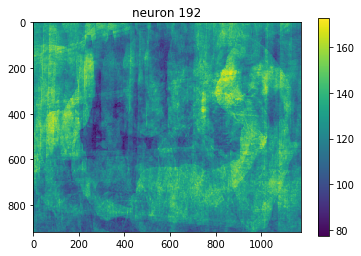

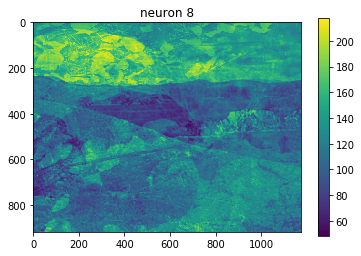

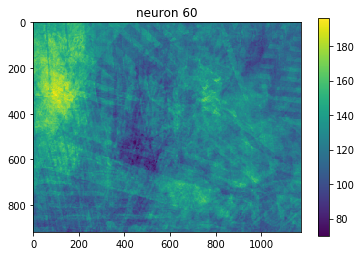

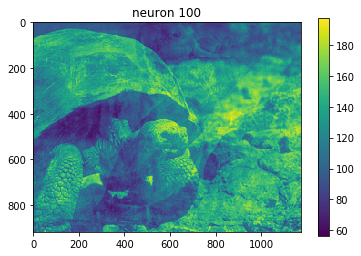

In [11]:
s_array = []
j = 0
for i in neuron_indices:
    S = detect_events(data_set, i, "natural_scenes")
    s_array.append(S)
    plt.figure()
    plt.imshow(stimulus_template[s_array[j]].mean(0))
    plt.title("neuron {}".format(i))
    plt.colorbar()
    j += 1

In [12]:
stim_reshaped = stimulus_template.reshape((T_frames, -1))

In [ ]:
# Create a matrix with stimulus at each frame.
# This is the input
# dimension:  number of frames x number of pixels
X = np.zeros((T, s1 * s2))
for t in range(T_frames):
    X[stimulus_table.start[t]:stimulus_table.end[t]] = stim_reshaped[t]

In [ ]:
# Create the output
# dimension: number of frames x number of neurons
# Y = dff[5].reshape((T, 1))
Y = dff.T

In [ ]:
# Standardize the inputs and outputs
X -= X.mean()
X /= X.std()

Y -= Y.mean(axis=0)
Y /= Y.std(axis=0)

In [ ]:
import math
class SpatioTemporalLinearModel(torch.nn.Module):
    def __init__(self, N_neurons, N_pixels, N_lags):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(SpatioTemporalLinearModel, self).__init__()
        self.w_spac = Parameter(torch.Tensor(N_neurons, N_pixels))
#         self.w_temp = Parameter(torch.Tensor(N_neurons, N_lags))
#         self.bias = Parameter(torch.Tensor(N_neurons))
        self.conv = nn.Conv1d(N_neurons, N_neurons, N_lags, padding=N_lags-1, groups=N_neurons)
        self.N_lags = N_lags
        self.N_pixels = N_pixels
        self.N_neurons = N_neurons
        
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.w_spac.size(1))
        self.w_spac.data.uniform_(-stdv, stdv)
#         self.w_temp.data.uniform_(-stdv, stdv)
#         if self.bias is not None:
#             self.bias.data.uniform_(-stdv, stdv)

    @property
    def w_temp(self):
        # weights is N_neurons x N_neurons x N_lags
        # we hope that its zero for [i,j,:] where i != j
        return self.conv.weight[:,0,:]
    
    @property
    def bias(self):
        # This should be N_neurons
        return self.conv.bias

    def forward(self, x):
        T = x.shape[0]
        
        x_tilde = torch.mm(x, self.w_spac.t())
        
#        y_pred = np.array([np.convolve(w, xn) for xn in x_tilde.T]).T
#         w = self.w_temp.data.numpy()
#         w_flip = w[::-1])
#         conv.weight.data = torch.from_numpy(w_flip.reshape((1, 1, -1)).astype(np.float32))
#         conv.bias.data = self.bias
        y_pred = self.conv(x_tilde.t().unsqueeze(0))
        y_pred = y_pred[0,:,:].t()
        
        # Undo padding
        y_pred = y_pred[:T]
        
#         y_pred = torch.nn.conv(self.w_temp, x_tilde, 1)
#        y_pred = torch.addmm(self.bias, x, self.w_spac.t() * self.w_temp[:,0])
#         for delta_t in range(1, self.N_lags):
#             y_pred[delta_t:] += torch.mm(x[:-delta_t], self.w_spac.t() * self.w_temp[:,delta_t])
#         for delta_t in range(1, self.N_lags):
#             y_pred[delta_t:] += torch.mm(x[:-delta_t], self.w_spac.t() * self.w_temp[:, delta_t])

        return y_pred

In [ ]:
# Get input and output shapes
N, D_in = X.shape
N2, D_out = Y.shape
assert N == N2

In [ ]:
model = SpatioTemporalLinearModel(D_out, D_in, 25)

In [ ]:
model.w_spac.data.numpy().shape

In [ ]:
model.w_temp.shape

In [ ]:
X_tensor = torch.FloatTensor(X)
Y_tensor = torch.FloatTensor(Y)

In [ ]:
criterion = torch.nn.MSELoss(size_average=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
# optimizer = torch.optim.LBFGS(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(X_tensor)

    # Compute and print loss
    loss = criterion(y_pred, Y_tensor)
    losses.append(loss.item())
    if t % 1 == 0:
        print(t, loss)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
plt.plot(losses)

In [ ]:
w_spac = model.w_spac[1].data.numpy().reshape(s1, s2)
w_temp = model.w_temp[1,0,].data.numpy()

In [ ]:
plt.figure()
plt.plot(w_temp)

In [ ]:
plt.imshow(w_spac)
plt.colorbar()

In [ ]:
# Try sklearn linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X[:-10], Y[10:])

In [ ]:
lr.coef_.shape

In [ ]:
plt.figure()
neuron = 98
lim = abs(lr.coef_[neuron]).max()
plt.imshow(lr.coef_[neuron].reshape((s1, s2)), vmin=-lim, vmax=lim, cmap="RdBu")
plt.colorbar()

In [ ]:
# Ypred = lr.predict(X[:-10])
Ypred = model(X_tensor).data.numpy()
mse = np.mean((Ypred - Y[10:])**2)
mse